In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import copy
import geopandas as gp

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import gen_decomposition, gen_laplacian, add_noise, train_mask
from nmf import nmf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Graphing preliminaries

In [4]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

In [5]:
from collections import OrderedDict

linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [6]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [7]:
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]
my_pal = get_continuous_cmap(h_list)

## New England + New York County Data

In [71]:
 # importing
new_eng_dataset = pd.read_csv(os.path.join(par, "covid_dataset/us_county/dataset.csv"), index_col = [0,1,2])
new_eng_laplacian = pd.read_csv(os.path.join(par, "covid_dataset/us_county/laplacian.csv"), index_col = 0)
new_eng_laplacian.columns = new_eng_laplacian.columns.astype(np.int64)
new_eng_laplacian.index = new_eng_laplacian.index.astype(np.int64)
new_eng_population = pd.read_csv(os.path.join(par, "covid_dataset/us_county/population.csv"), index_col = [0,1,2,3])
#new_eng_population.loc[:, 'population_estimate'] = population.loc[:, 'population_estimate'].astype(np.float64)

# json file with geographic info for each state -- required for graphing
county_map = os.path.join(par, 'covid_dataset/us_county/geography.json')

In [72]:
# I will stick with FIPS codes as a naming convention. For full county name + state it's in a backwards lookup would suffice.
# filtering out the new england region counties:
new_eng_dataset = new_eng_dataset.loc[new_eng_dataset.index.get_level_values("state").isin(["New York", "Connecticut", "Maine", "Vermont",
                                                       "Massachusetts", "New Hampshire", "Rhode Island"])]
new_eng_dataset.index = new_eng_dataset.index.get_level_values(2)
new_eng_population.index = new_eng_population.index.get_level_values(3)
new_eng_laplacian = new_eng_laplacian.loc[new_eng_dataset.index, new_eng_dataset.index]

In [74]:
# Normalize by population
new_eng_dataset = new_eng_dataset.T

for col in new_eng_dataset.columns:
    new_eng_dataset.loc[:,col] /= new_eng_population.loc[col, 'population_estimate'].item() 

### Grid Search

**Given the computational cost of a grid search I have chosen to exclude it from the notebook. I have tried to make the process simple and easy to follow by including the grid_search.py file in the repository.** To find the best set of parameters for which diffusion-nmf performs best we chose to try a range of different rank and beta (spread parameter) combinations. We choose final values by analyzing the trends shown in the graph and finding parameter combinations that give small relative error. 

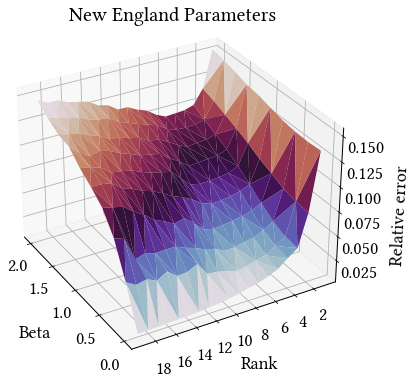

In [46]:
new_eng_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/new_eng_rank_beta.csv"))
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid['beta'], state_grid['rank'], state_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("New England Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

### Results

In [76]:
# A quick function to rescale the results for better presentation
# does not affect trends in the output
def rescale(X,V,K = None):
    X = copy.deepcopy(X)
    V = copy.deepcopy(V)

    maxer = np.amax(X)
    X /= maxer
    V *= maxer
    
    return X,V

In [77]:
# prepare parameters
rank = 5
beta = 1
K = np.linalg.inv(np.identity(len(new_eng_laplacian)) + beta * new_eng_laplacian.to_numpy())

# diffusion nmf (takes a minute or so)
dNMF = diff_nmf(n_components = rank, kernel = K, n_iter = 200000  , tol = 1e-10)
X,V = dNMF.fit_transform(new_eng_dataset)

Max iterations reached, increase to converge on given tolerance


In [78]:
# regular nmf for comparison
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
W,H = nmfer.fit_transform(new_eng_dataset)

Max iterations reached, increase to converge on given tolerance


In [79]:
#rescaling
X,V = rescale(X,V,K)
X = pd.DataFrame(X, index = new_eng_dataset.index)
V = pd.DataFrame(V, columns = new_eng_dataset.columns)

W,H = rescale(W,H)
W = pd.DataFrame(W, index = new_eng_dataset.index)
H = pd.DataFrame(H, columns = new_eng_dataset.columns)

In [ ]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [0,1,2,3,4]
X = X[reorder]
X.columns = standard
V = V.reindex(reorder)
V.index = standard 

# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [1,0,4,2,3]
W = W[reorder]
W.columns = standard
H = H.reindex(reorder)
H.index = standard 

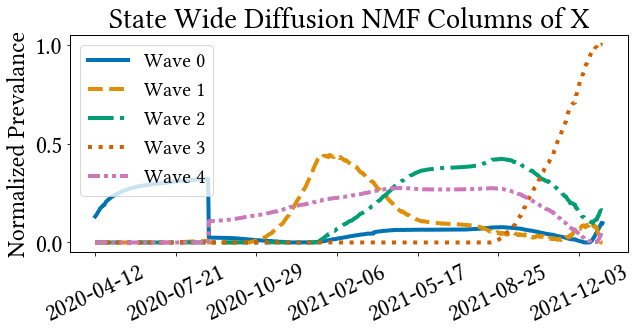

In [80]:
X.columns = ["Wave " + str(i) for i in range(rank)]

plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(X.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("State Wide Diffusion NMF Columns of X")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

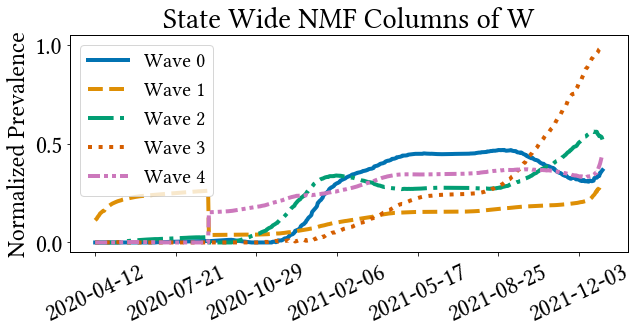

In [81]:
W.columns = ["Wave " + str(i) for i in range(rank)]

plt.rcParams["font.size"] = 24
W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(W.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()

plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalence")
plt.title("State Wide NMF Columns of W")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

### Error Checking